In [1]:
# Data

import numpy as np
import math
import pandas as pd
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from random import random

def Htot(z,Om,OL,w0,wa,H0,Or):
    H=H0*pow(Om*pow(1+z,3)+Or*pow(1+z,4)+OL+(1-OL-Or-Om)*pow(1+z,3*(1+w0+wa))*math.exp(-3*z*wa/(1+z)),0.5)
    return H    
    
# Import CCH data    
CCH_mean = np.loadtxt("CCHdata_2023b.dat")
CCH_cov = np.loadtxt("CCHcov_2023b.dat")
CCH_invcov = np.linalg.inv(CCH_cov)

# Import BAO_2D redshifts
BAO = np.loadtxt("2D_BAO.txt")
BAOred = np.zeros(len(BAO))
for i in range(len(BAO)):
    BAOred[i] = BAO[i,0]    

# Import CMB+BAO+SHOES data

comb_mean = np.loadtxt("MeanData_2D.txt")
comb_cov = np.loadtxt("covData_2D.txt")
comb_invcov = np.linalg.inv(comb_cov)

# Import Pantheon+ data
PantheonPlus_dataFull = np.loadtxt("Pantheon+SH0ES.dat", usecols=(2,4,8,12,13))
PantheonPlus_covRaw = np.loadtxt("Pantheon+SH0ES_STAT+SYS.cov")
PantheonPlus_covFull = np.zeros((len(PantheonPlus_dataFull),len(PantheonPlus_dataFull)))
count = 1
for i in range(len(PantheonPlus_dataFull)):
    for j in range(len(PantheonPlus_dataFull)):
        PantheonPlus_covFull[i][j] = PantheonPlus_covRaw[count]  
        count = count+1
        
PantheonPlus_data = []
item = []
for i in range(len(PantheonPlus_dataFull)):
    if PantheonPlus_dataFull[i][4]==1 or PantheonPlus_dataFull[i][0]>0.01:
        PantheonPlus_data.append([PantheonPlus_dataFull[i][0],PantheonPlus_dataFull[i][1],PantheonPlus_dataFull[i][2],PantheonPlus_dataFull[i][3],PantheonPlus_dataFull[i][4]])
        item.append(i)

        
PantheonPlus_cov = np.zeros((len(item),len(item)))  
for i in range(len(item)):
    for j in range(len(item)):    
        PantheonPlus_cov[i][j] = PantheonPlus_covFull[item[i]][item[j]]
 
N_Pan = len(item)
PantheonPlus_invcov = np.linalg.inv(PantheonPlus_cov)

np.savetxt('COVCOV.txt', PantheonPlus_cov, delimiter = ' ')
np.savetxt('DATDAT.txt', PantheonPlus_data, delimiter = ' ')


In [3]:
PantheonPlus_dataFull[0]

array([1.22000e-03, 1.22000e-03, 9.74571e+00, 2.91770e+01, 1.00000e+00])

In [15]:
##################################
#  LCDM  without Pantheon
##################################

# Hubble function

def H(z,w_m,H0):
        H=H0*pow(w_m*pow(1+z,3)/pow(H0/100,2)+ 4.18343*pow(10,-5)*pow(1+z,4)/pow(H0/100,2)+(1- 4.18343*pow(10,-5)/pow(H0/100,2)-w_m/pow(H0/100,2)),0.5)
        return H

def integrand(z,w_m,H0):
    return 1/H(z,w_m,H0)

# Matrix to perform jumps in parameter space: w_m, H0, logA, n_s, M
jump_matrix = [[comb_cov[1,1],0,comb_cov[1,2],comb_cov[1,3]],[0,0.5,0,0],[comb_cov[2,1],0,comb_cov[2,2],comb_cov[2,3]],
               [comb_cov[3,1],0,comb_cov[3,2],comb_cov[3,3]]]
loc = [comb_mean[1],67,comb_mean[2],comb_mean[3]]

# MCMC

N_MCMC=pow(10,4)
chi2_0 = pow(10,5)
results = []

for i in range(N_MCMC):
    x, y , z, t= np.random.multivariate_normal(loc, jump_matrix, 1).T
    w_m = x[0]
    H0 = y[0]
    logA = z[0]
    ns = t[0]    

    #CCH
    difH_th = np.zeros(len(CCH_mean))
    for j in range(len(CCH_mean)):
        difH_th[j] = H(CCH_mean[j,0],w_m,H0)- CCH_mean[j,1]    
    chi2_CCH = np.dot(np.dot(difH_th,CCH_invcov),difH_th)

    #comb
    difcomb = np.zeros(len(comb_mean))
    difcomb[0] = quad(integrand, 0,  1089.92,args=(w_m,H0))[0]*299792.458/1000 - comb_mean[0]
    difcomb[1] = w_m-comb_mean[1]
    difcomb[2] = logA-comb_mean[2]
    difcomb[3] = ns-comb_mean[3]
    for k in range(15):
        difcomb[k+4] =299792.458*quad(integrand, 0, BAOred[k],args=(w_m,H0))[0]/(1 + BAOred[k])-comb_mean[k+4]
    difcomb[19] = H0-comb_mean[19]    
    chi2_comb = np.dot(np.dot(difcomb,comb_invcov),difcomb)

    chi2 = chi2_CCH+chi2_comb
  
    if chi2<chi2_0:
        results.append([chi2,w_m,H0,logA,ns])
        chi2_0 = chi2
        loc = [w_m,H0,logA,ns]
    else:
        alpha = random()
        if math.exp(0.5*(-chi2+chi2_0))>alpha:
            results.append([chi2,w_m,H0,logA,ns])
            chi2_0 = chi2
            loc = [w_m,H0,logA,ns]
        else:
            results.append([chi2_0,loc[0],loc[1],loc[2],loc[3]])
            
np.savetxt('LCDM_CMB+BAO.txt', results, delimiter = ' ')

Removed no burn in
chi2_min= 71.12930914077063


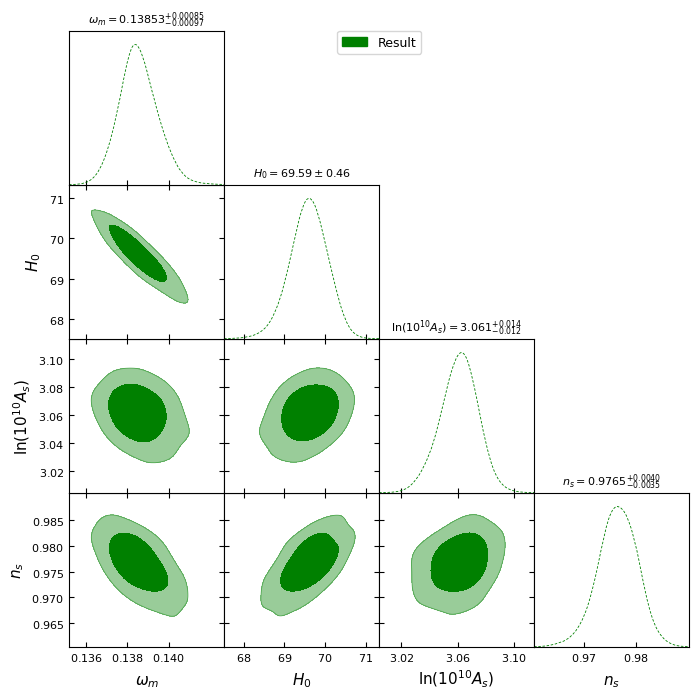

In [16]:
# MCMC output

results_array=np.ndarray(shape=(len(results),4), dtype=float)
for i in range(len(results)):
    results_array[i,0] = results[i][1]
    results_array[i,1] = results[i][2]
    results_array[i,2] = results[i][3]
    results_array[i,3] = results[i][4]

from getdist import plots, MCSamples
import getdist
import numpy as np

ndim = 4
samps = results_array
names = ["x%s"%i for i in range(ndim)]
labels =  [r'\omega_{m}',r'H_0',r'\ln(10^{10} A_s)',r'n_s']
samples = MCSamples(samples=samps,names = names, labels = labels,ignore_rows=0)
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True,legend_labels=['Result'],line_args=[{'ls':'--', 'color':'green'},{'lw':2, 'color':'darkblue'}], 
                contour_colors=['green'],title_limit=1)

chi2_list=np.zeros(len(results))
for i in range(len(results)):
    chi2_list[i]=results[i][0]
print("chi2_min=",min(chi2_list))



In [14]:
def H(z,w_m,H0):
        H=H0*pow(w_m*pow(1+z,3)/pow(H0/100,2)+ 4.18343*pow(10,-5)*pow(1+z,4)/pow(H0/100,2)+(1- 4.18343*pow(10,-5)/pow(H0/100,2)-w_m/pow(H0/100,2)),0.5)
        return H

def integrand(z,w_m,H0):
    return 1/H(z,w_m,H0)

w_m = 0.1803
H0 = 73.03
M = -19.253

difPan = np.zeros(N_Pan)
for k in range(N_Pan):
    if PantheonPlus_data[k][4]==0:
        difPan[k] = M+25+5*math.log(299792.458*(1+PantheonPlus_data[k][1])*quad(integrand, 0, PantheonPlus_data[k][0],args=(w_m,H0))[0],10) - PantheonPlus_data[k][2]   
    else:
        difPan[k] = M + PantheonPlus_data[k][3] - PantheonPlus_data[k][2]   
chi2_Pan = np.dot(np.dot(difPan,PantheonPlus_invcov),difPan)
print(chi2_Pan)
print(len(PantheonPlus_invcov))
prova = np.loadtxt("COVCOV.txt")
print(prova[0])

1453.397205686145
1657
[ 3.177108e-02  5.754430e-03  3.100600e-04 ...  2.945500e-04 -8.595000e-05
 -2.701100e-04]


In [9]:
##################################
#  LCDM  with Pantheon
##################################

comb_mean = np.loadtxt("MeanData_2D.txt")
comb_cov = np.loadtxt("covData_2D.txt")
comb_mean2 = comb_mean
comb_cov2 = comb_cov
comb_mean = np.zeros((len(comb_mean2)-1))
comb_cov = np.zeros((len(comb_mean2)-1,len(comb_mean2)-1))
for i in range(len(comb_mean)):
    comb_mean[i] = comb_mean2[i]
    for j in range(len(comb_mean)):
        comb_cov[i][j] = comb_cov2[i][j]        

comb_invcov = np.linalg.inv(comb_cov)


# Hubble function

def H(z,w_m,H0):
        H=H0*pow(w_m*pow(1+z,3)/pow(H0/100,2)+ 4.18343*pow(10,-5)*pow(1+z,4)/pow(H0/100,2)+(1- 4.18343*pow(10,-5)/pow(H0/100,2)-w_m/pow(H0/100,2)),0.5)
        return H

def integrand(z,w_m,H0):
    return 1/H(z,w_m,H0)

# Matrix to perform jumps in parameter space: w_m, H0, logA, n_s, M
jump_matrix = [[comb_cov[1,1],0,comb_cov[1,2],comb_cov[1,3],0],[0,0.5,0,0,0],[comb_cov[2,1],0,comb_cov[2,2],comb_cov[2,3],0],[comb_cov[3,1],0,comb_cov[3,2],comb_cov[3,3],0],[0,0,0,0,pow(0.03,2)]]
loc = [comb_mean[1],67,comb_mean[2],comb_mean[3],-19.35]


# MCMC

N_MCMC=pow(10,4)
chi2_0 = pow(10,20)
results = []

for i in range(N_MCMC):
    x, y , z, t, u= np.random.multivariate_normal(loc, jump_matrix, 1).T
    w_m = x[0]
    H0 = y[0]
    logA = z[0]
    ns = t[0]
    M = u[0]

    #CCH
    difH_th = np.zeros(len(CCH_mean))
    for j in range(len(CCH_mean)):
        difH_th[j] = H(CCH_mean[j,0],w_m,H0)- CCH_mean[j,1]    
    chi2_CCH = np.dot(np.dot(difH_th,CCH_invcov),difH_th)

    #comb
    difcomb = np.zeros(len(comb_mean))
    difcomb[0] = quad(integrand, 0,  1089.92,args=(w_m,H0))[0]*299792.458/1000 - comb_mean[0]
    difcomb[1] = w_m-comb_mean[1]
    difcomb[2] = logA-comb_mean[2]
    difcomb[3] = ns-comb_mean[3]
    for k in range(15):
        difcomb[k+4] =299792.458*quad(integrand, 0, BAOred[k],args=(w_m,H0))[0]/(1 + BAOred[k])-comb_mean[k+4]    
    chi2_comb = np.dot(np.dot(difcomb,comb_invcov),difcomb)

    #Pantheon
    difPan = np.zeros(N_Pan)
    for k in range(N_Pan):
        if PantheonPlus_data[k][4]==0:
            difPan[k] = M+25+5*math.log(299792.458*(1+PantheonPlus_data[k][1])*quad(integrand, 0, PantheonPlus_data[k][0],args=(w_m,H0))[0],10) - PantheonPlus_data[k][2]   
        else:
            difPan[k] = M + PantheonPlus_data[k][3] - PantheonPlus_data[k][2]   
    chi2_Pan = np.dot(np.dot(difPan,PantheonPlus_invcov),difPan)     

    chi2 = chi2_CCH+chi2_comb+chi2_Pan
  
    if chi2<chi2_0:
        results.append([chi2,w_m,H0,logA,ns,M])
        chi2_0 = chi2
        loc = [w_m,H0,logA,ns,M]
    else:
        alpha = random()
        if math.exp(0.5*(-chi2+chi2_0))>alpha:
            results.append([chi2,w_m,H0,logA,ns,M])
            chi2_0 = chi2
            loc = [w_m,H0,logA,ns,M]
        else:
            results.append([chi2_0,loc[0],loc[1],loc[2],loc[3],loc[4]])

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
np.savetxt('LCDM_CMB+BAO+SNIa.txt', results, delimiter = ' ')

Removed no burn in
chi2_min= 1539.2907580091182


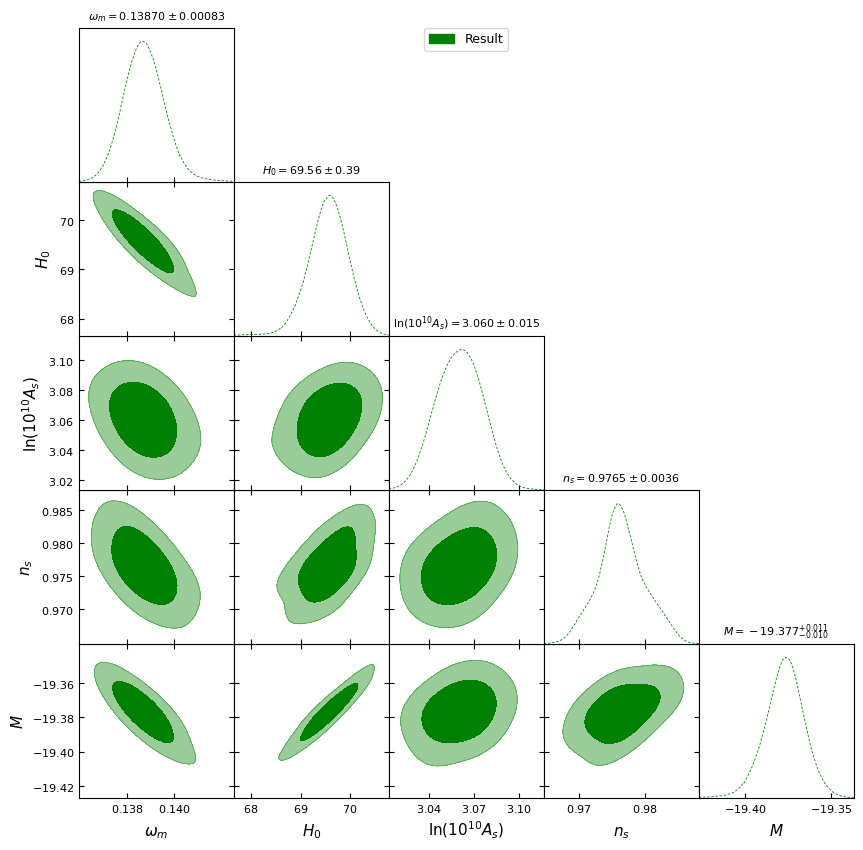

In [11]:
# MCMC output

results_array=np.ndarray(shape=(len(results),5), dtype=float)
for i in range(len(results)):
    results_array[i,0] = results[i][1]
    results_array[i,1] = results[i][2]
    results_array[i,2] = results[i][3]
    results_array[i,3] = results[i][4]
    results_array[i,4] = results[i][5]

from getdist import plots, MCSamples
import getdist
import numpy as np

ndim = 5
samps = results_array
names = ["x%s"%i for i in range(ndim)]
labels =  [r'\omega_{m}',r'H_0',r'\ln(10^{10} A_s)',r'n_s',r'M']
samples = MCSamples(samples=samps,names = names, labels = labels,ignore_rows=0)
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True,legend_labels=['Result'],line_args=[{'ls':'--', 'color':'green'},{'lw':2, 'color':'darkblue'}], 
                contour_colors=['green'],title_limit=1)

chi2_list=np.zeros(len(results))
for i in range(len(results)):
    chi2_list[i]=results[i][0]
print("chi2_min=",min(chi2_list))

In [76]:
# Refine jumpingcovariance matrix 

data = np.loadtxt("LCDM_CMB+BAO+SNIa.txt")
new_cov = np.zeros((5,5))
means = np.zeros((5))

for i in range(5):
    for k in range(len(data)):
        means[i]=means[i]+data[k][i+1]/len(data)
        
for i in range(5):
    for j in range(5):
        for k in range(len(data)):
            new_cov[i][j]=(data[k][i+1]-means[i])*(data[k][j+1]-means[j])/len(data)

            